In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

In [3]:
california_ozone = pd.read_csv("../dataset/cal_o3.csv", index_col = None)

In [4]:
cadf = california_ozone
cadf = cadf[cadf['Time Local'] <= '18:00']
cadf = cadf[cadf['Time Local'] >= '10:00']

In [5]:
county_codes = cadf['County Code'].values
site_code = cadf['Site Num'].values
site_id = [str(county_codes[i]) + str(site_code[i]) for i in range(len(county_codes))]

In [6]:
cadf['ID'] = site_id

In [7]:
cadf.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change', 'ID'],
      dtype='object')

In [8]:
mask = cadf.groupby(['ID', 'Date Local'])['Sample Measurement'].count() >= 8

In [9]:
cadf = cadf.groupby(['ID', 'Date Local']).mean()[mask]

In [10]:
cadf.reset_index(inplace=True)

In [11]:
cadf = cadf[['ID', 'Date Local', 'Latitude', 'Longitude', 'Sample Measurement']]

In [12]:
m1 = cadf['Date Local'] >= '1990-05-01'
m2 = cadf['Date Local'] <= '1990-09-30'
mf = m1 & m2
cadf = cadf[mf]

In [13]:
m4 = cadf.groupby('ID').count()>=115

In [14]:
cadf = cadf.groupby('ID').mean()[m4]

In [15]:
cadf.dropna(inplace = True)

In [16]:
ca_df = cadf.copy()

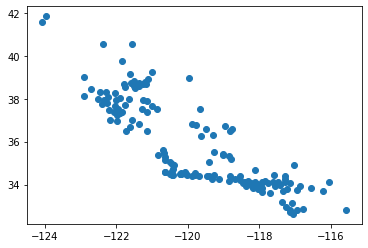

In [17]:
plt.scatter(cadf['Longitude'], cadf['Latitude'])

## Let us load California Centroids for Interpolation

### Before that, let us visualize California and nearby regions!

In [18]:
import geopandas as gpd

Venture - 111, Orange - 59, Riverside - 65, San Bernardino - 71, LA - 36

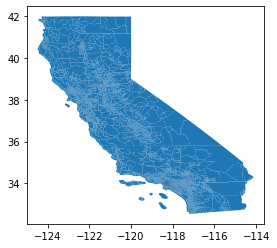

In [19]:
gdf = gpd.read_file("../block_groups/california/tl_2016_06_bg.shp")
# gdf = gdf[gdf['COUNTYFP'].isin(['037', '059', '111'])]
gdf['INTPTLAT'] = np.float64(gdf['INTPTLAT'].values)
gdf['INTPTLON'] = np.float64(gdf['INTPTLON'].values)
# gdf = gdf[gdf['INTPTLAT']>=33.6]
# gdf = gdf[gdf['INTPTLAT']<=35.5]
# gdf = gdf[gdf['INTPTLON']>=-119.4]
gdf.plot()

## The 10 counties are those mentioned in Wikipedia for South California

In [20]:
scgdf = gdf[gdf['COUNTYFP'].isin(['025','026','037','059','065','071','073','079','083','111'])]

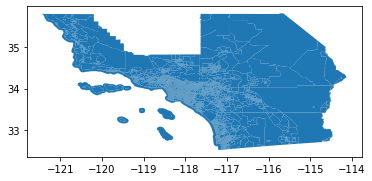

In [21]:
scgdf.plot()

In [22]:
shapes = scgdf['geometry'].unique()
centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
centroids = np.array(centroids)

In [23]:
centroids.shape

(13167, 2)

## We are only interested in california for Kriging Interpolation of O3

## Let us interpolate over California!

In [24]:
cadf1 = cadf.copy()

In [25]:
cadf1 = cadf1[cadf1['Latitude']<=35.7839132]

In [26]:
X = cadf1[['Longitude', 'Latitude']].values
y = cadf1[['Sample Measurement']].values * 1000

### Kriging Interpolation

In [27]:
from polire.interpolate import Kriging
## PyKrige takes Longitude Values in the Range 0 to 360 => Add 360 to our values!
X_krig = X.copy()
X_test_krig = centroids.copy()
# X_krig[:, 0] = X_krig[:, 0] + 360
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X_krig, y)

X_test_krig[:, 0] = X_test_krig[:, 0] + 360
krig_predictions = krig.predict(X_test_krig)

### Spatial Average

In [28]:
from polire.interpolate import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)
spatial_predictions = spatial.predict(centroids)

### IDW

For IDW, the authors choose a 250 km radius. Let us likewise choose our training points and use the IDW Class repeatedly.

polire supports geographic coordinates and hence we have that distance too!

In [29]:
from polire.interpolate import Idw
from polire.utils.distance import haversine, euclidean
idw = Idw(coordinate_type='Geographic', exponent=1)
idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    idw.fit(X_train, y_train)
    idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [30]:
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
knn_predictions = knn.predict(centroids)

In [31]:
krig_predictions = np.array(krig_predictions).reshape(-1,)

In [32]:
spatial_predictions = np.array(spatial_predictions).reshape(-1,)

In [33]:
idw_predictions = np.array(idw_predictions).reshape(-1,)

In [34]:
temp = []
for i in spatial_predictions:
    try:
        j = i[0]
        temp.append(j)
    except:
        temp.append(i)

In [35]:
spatial_predictions = spatial_predictions[~np.isnan(temp)]

In [36]:
krig_predictions.mean(), idw_predictions.mean(), spatial_predictions.mean(), knn_predictions.mean()

(57.11764087046979,
 58.282378295802204,
 array([55.23232689]),
 54.68536373627176)

## SOCAL PREDICTION ABOVE

In [37]:
def predict(gdf, df, lat):
    df = df[df['Latitude']<=lat]
    gdf = gdf[gdf['INTPTLAT']<=lat]
    shapes = gdf['geometry'].unique()
    centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
    centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
    centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
    centroids = np.array(centroids)
    X = df[['Longitude', 'Latitude']].values
    y = df[['Sample Measurement']].values * 1000
    
    
    from polire.interpolate import Idw
    from polire.utils.distance import haversine, euclidean
    idw = Idw(coordinate_type='Geographic', exponent=1)
    idw_predictions = np.zeros(centroids.shape[0])
    for ix, data_point in enumerate(centroids):
        distances = haversine(data_point, X)
        mask = distances <= 250
        X_train = X[mask]
        y_train = y[mask]
        idw.fit(X_train, y_train)
        idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))
    
    from polire.custom import CustomInterpolator
    from sklearn.neighbors import KNeighborsRegressor
    knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
    knn.fit(X, y)
    knn_predictions = knn.predict(centroids)
    
    from polire.interpolate import SpatialAverage
    spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
    spatial.fit(X, y)
    spatial_predictions = spatial.predict(centroids)
    temp = []
    for i in spatial_predictions:
        try:
            j = i[0]
            temp.append(j)
        except:
            temp.append(i)
    spatial_predictions = spatial_predictions[~np.isnan(temp)]   
    
    
    from polire.interpolate import Kriging
    X_krig = X.copy()
    X_test_krig = centroids.copy()
    # X_krig[:, 0] = X_krig[:, 0] + 360
    krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
    krig.fit(X_krig, y)

    X_test_krig[:, 0] = X_test_krig[:, 0] + 360
    krig_predictions = krig.predict(X_test_krig)
    
    print(krig_predictions.mean(), idw_predictions.mean(), spatial_predictions.mean(), knn_predictions.mean())
    
    
    
    

In [38]:
for i in np.linspace(35,45,21):
    print(i)
    predict(gdf, cadf, i)

35.0
56.6885347037593 58.33406423830522 [55.45425574] 54.92813709530413
35.5
55.2388361797276 58.371429066626106 [55.55427698] 55.06366032668049
36.0
57.42365418751343 58.33548378162463 [55.53963904] 55.09763531055316
36.5
56.81529426236536 58.255521638577434 [55.63032187] 55.24816146136425
37.0
57.61955812223251 57.714595286435014 [55.40406025] 54.996253853696885
37.5
55.82477582391535 55.76877545808765 [53.64077778] 53.3810975352638
38.0
51.5148279450552 51.948943641960945 [49.33137175] 49.224964397306486
38.5
50.82761276813963 51.22793779399005 [48.76339843] 48.68061312923772
39.0
51.00970343542912 51.34803587748715 [48.76983038] 48.68737389760437
39.5
50.98656880635151 51.27532229812348 [48.76708606] 48.650088615646546
40.0
50.46149387747987 51.21712269113345 [48.7548882] 48.62967743572559
40.5
50.44560363983849 51.19294674189088 [48.7548882] 48.62286832007122
41.0
49.757849918637376 51.183800359098825 [48.77634788] 48.67418854475979
41.5
49.75856934286474 51.18033935173616 [48.776